In [5]:
# Napisz sprawozdanie w markdownie do zadania:
# 1 Treść zadania
# Celem ćwiczenia jest transformacja współrzędnych elipsoidalnych lecącego samolotu do układu
# lokalnego. Danymi do zadania są współrzędne geodezyjne: szerokość φ oraz długość λ, a także
# wysokość h samolotu odniesiona do poziomu jednego z lotnisk, podane w pewnych krótkich od-
# stępach czasu. Dane zawarte są w plikach .csv, pobranych z portalu flightradar24.com.
# Współrzędne te należy przeliczyć najpierw do geocentrycznych współrzędnych ortokartezjań-
# skich, a ostatecznie do układu współrzędnych horyzontalnych (układ lokalny, topocentryczny),
# względem znanego położenia lotniska. Należy również wyznaczyć moment, w którym samolot
# zniknie poniżej horyzontu (przyjąć moment, kiedy wysokość horyzontalna h = 0). Należy wyko-
# nać odpowiednie wizualizacje.
# Przykładowe wizualizacje to:
# • mapa, przedstawiająca trasę przelotu samolotu z lotniska A do B. W tym przypadku może
# warto poeksperymentować z odwzorowaniem mapy lub jej podkładem. Można spróbować
# przedstawić również idealny przebieg trasy pomiędzy dwoma lotniskami, rysując na mapie
# linię geodezyjną pomiędzy nimi. Podpowiedź do wykonania mapy w języku python, z
# wykorzystaniem pakietu cartopy, można znaleźć w pliku tekstowym dołączonym do danych
# do ćwiczenia. Dodatkowo, polecane pakiety do wykonania takiej wizualizacji to folium
# oraz plotly, z funkcją Scattergeo;
# • wykres skyplot – przedstawienie położenia samolotu w układzie lotniska początkowego
# (lub docelowego) do momentu zniknięcia/pojawienia się na horyzoncie: w przypadku tego
# wykresu mogą pojawić się pewne problemy z ich czytelnością, ponieważ w momencie ko-
# łowania mogą się pojawić ujemne wartości kąta elewacji, a poza tym wysokość samolotu
# względem lotniska będzie niska, toteż wykres ten prawdopodobnie nie będzie wyglądał
# optymalnie. Rozwiązaniem może być zmiana wysokości elispoidalnej lotniska (na mniej-
# szą), wykonanie wykresu skyplot dla miejsca położonego na trasie lotu samolotu. Ale
# najlepszy rozwiązaniem wydaje się być przedstawienie na osi Y zamiast elewacji samolotu,
# to odległości od lotniska;
# • wykres zmian wysokości lotu samolotu w zależności od czasu;
# 1
# • * wykres zmian prędkości lotu samolotu;
# • * wykres zmiany odległości samolotu od lotniska.
# Liczę na inwencję twórczą. Wymienione typy wykresów to jedynie sugestie. Nie wszystkie
# muszę znaleźć się w pracy. Może ktoś wpadnie na pomysł jeszcze ciekawszej wizualizacji lotu
# samolotu.
# 2 Kolejność wykonywania zadania
# Dane:
# • współrzędne lotniska φ, λ, h – pierwszy rekord pliku z danymi;
# • współrzędne samolotu φ, λ, h – pozostałe rekordy pliku z danymi.
# 1. Przeliczenie współrzędnych φ, λ, h lotniska i samolotu do współrzędnych ortokartezjań-
# skich X, Y, Z:
# X = (N + h) cos φ cos λ
# Y = (N + h) cos φ sin λ
# Z = [N (1 − e2) + h] sin φ
# gdzie:
# • N to promień przekroju Ziemi w kierunku I Wertykału:
# N = a
# √1 − e2 sin2 φ
# • a i e2 to wielka półoś i kwadrat pierwszego mimośrodu dla elipsoidy GRS80:
# a = 6 378 137 m
# e2 = 0.006 694 380 022 90
# • φ, λ, h – współrzędne geodezyjne
# 2. Obliczenie wektora samolot – lotnisko⃗ Xs
# l we współrzędnych ortokartezjańskich (geocen-
# trycznych):⃗
# Xs
# l =⃗ Xs −⃗ Xl
# gdzie⃗ Xl i⃗ Xs to odpowiednio wektor współrzędnych XYZ lotniska i samolotu
# 3. Kolejnym krokiem jest wykonanie transformacji współrzędnych wektora⃗ Xs
# l do układu
# współrzędnych lokalnych.
# Układ współrzędnych lokalnych można zdefiniować wprowadzając wektor normalny do
# elipsoidy w danym punkcie,⃗u , który przyjmuje postać:⃗
# u =
# 
# 
# 
# cos φ cos λ
# cos φ sin λ
# sin φ
# 
# 
#  (1)
# gdzie φ i λ są to współrzędne danego punktu (miejsca obserwacji, czyli w naszym przy-
# padku lotniska).
# Pozostałe osie otrzymamy obliczając pochodną z wektora normalnego względem φ oraz λ.
# Otrzymamy w ten sposób osie:⃗n – zwróconą w kierunku północy, oraz⃗e – zwróconą o kąt
# 90◦ w prawo od osi⃗n :⃗
# n = δu
# δφ
# 
# 
# 
# − sin φ cos λ
# − sin φ sin λ
# cos φ
# 
# 
# ⃗ e = 1
# cos φ
# δu
# δλ
# 
# 
# 
# − sin λ
# cos λ
# 0
# 
# 
#  (2)
# 2
# Łącząc wektory kierunkowe układu lokalnego, otrzymamy macierz obrotu między układem
# współrzędnych geocentrycznych i lokalnych:
# Rneu =
# [⃗
# n⃗e⃗u
# ]
# =
# 
# 
# 
# − sin φ cos λ − sin λ cos φ cos λ
# − sin φ sin λ cos λ cos φ sin λ
# cos φ 0 sin φ
# 
# 
#  (3)
# Macierz Rneu jest macierzą ortogonalną, zatem RT
# neu = R−1
# neu.
# Transformacja wektora w układzie geocentrycznym XYZ do układu lokalnego neu, reali-
# zowana jest przez działanie:⃗
# x s
# lneu = RT
# neu ·⃗ Xs
# l =
# 
# 
# 
# n
# e
# u
# 
# 
#  (4)
# Składowymi wektora⃗x s
# lneu są odpowiednio:
# 
# 
# 
# n
# e
# u
# 
# 
#  =
# 
# 
# 
# s sin z cos Az
# s sin z sin Az
# s cos z
# 
# 
#  (5)
# gdzie:
# • s – długość wektora:
# s = √
# n2 + e2 + u2
# • Az – azymut:
# Az = arctan e
# n
# • z – kąt zenitalny: z = 90◦ − h;
# h = arcsin
# ( u
# √n2 + e2 + u2
# )
# (6)
# 3 Dane
# Do odczytu danych służy funkcja read_flightradar, dla której argumentem wejściowym
# jest ścieżka pliku .csv, zawierającego dane. Wynik działania opisany jest w treści funkcji.
# 4 Uwagi
# Wysokości w pliku podane są w stopach. Wysokości ten należy przeliczyć do metrów,
# mnożąc razy 0.3048. Dodatkowo, wysokości te podane są względem lotniska początkowego (w
# trakcie lotu, poziom odniesienia zmieniany jest na lotnisko docelowe, natomiast dla uproszczenia
# przyjmijmy, że wszystkie wysokości w pliku odniesione są do lotniska początkowego). Aby przeli-
# czyć daną wysokość do wysokości elipsoidalnej, należy do wszystkich wysokości dodać wysokość
# normalną oraz odstęp elipsoidy od quasigeoidy (ponownie, upraszczając jako poziom odniesienia
# dla całego przelotu przyjmujemy poziom lotniska początkowego – Okęcia). Będą to odpowiednia:
# • hnorm = 104 m
# • ζ = 31.4 m
# • hel = hnorm + ζ
# W danych intencjonalnie nie zostały wpisane destynacje lotów. Warto sprawdzić samemu,
# jaki rejs się analizuje.
# 3
# 5 Dla chętnych
# • Podobne przeliczenie można wykonać dla lotniska przylotu. Wtedy natomiast niepraw-
# dziwe będą wartości wysokości normalnej lotniska oraz odstępu elipsoidy od quasigeoidy
# w tym miejscu (można przyjąć wysokość względem lotniska jako elipsoidalną).
# • Obliczenia można wykonać również dla dowolnego innego lotu, dla którego dane można
# znaleźć na portalu flightradar24.com

## Transformacja współrzędnych elipsoidalnych samolotu na kartezjańskie

Autor: **Radosław Dąbkowski**

Numer indeksu: **325683**

### Wstęp

W ramach zadania zaimplementowano program, który na podstawie danych lotu samolotu we współrzędnych elipsoidalnych (szerokość, długość, wysokość) wyznacza współrzędne kartezjańskie (x, y, z).

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 17 12:38:20 2022

@author: mgrzy
"""

import numpy as np

def read_flightradar(file) -> np.array:
    '''
    Parameters
    ----------
    file : .csv file - format as downloaded from fligthradar24
        DESCRIPTION.
    Returns
    -------
    all_data : numpy array
        columns are:
            0 - Timestamp - ?
            1 - year
            2 - month
            3 - day
            4 - hour
            5 - minute
            6 - second
            7 - Latitude [degrees]
            8 - Longitude [degrees]
            9 - Altitude [feet]
            10 - Speed [?]
            11 - Direction [?]
    '''
    with open(file, 'r') as f:
        i = 0
        size= []
        Timestamp = []; date = []; UTC = []; Latitude = []; Longitude = []; 
        Altitude = []; Speed = []; Direction = []; datetime_date = []
        for linia in f:
            if linia[0:1]!='T':
                splited_line = linia.split(',')
                size.append(len(splited_line))
                i+=1
                Timestamp.append(int(splited_line[0]))
                full_date = splited_line[1].split('T')
                date.append(list(map(int,full_date[0].split('-'))))
                UTC.append(list(map(int, full_date[1].split('Z')[0].split(':'))))
                Callsign = splited_line[2]
                Latitude.append(float(splited_line[3].split('"')[1]))
                Longitude.append(float(splited_line[4].split('"')[0]))
                Altitude.append(float(splited_line[5]))
                Speed.append(float(splited_line[6]))
                Direction.append(float(splited_line[7]))
                
    all_data = np.column_stack((np.array(Timestamp), np.array(date), np.array(UTC),
                                np.array(Latitude), np.array(Longitude), np.array(Altitude),
                                np.array(Speed), np.array(Direction)))
    return all_data

def blh2xyz(fi, lam, h) -> np.array:
    '''
    Parameters
    ----------
    fi : float
        latitude [rad].
    lam : float
        longitude [rad].
    h : float
        height [m].
    Returns
    -------
    xyz : numpy array
        x, y, z [m].
    '''
    a = 6378137.0
    e2 = 0.00669438002290
    N = a/np.sqrt(1-e2*np.sin(fi)**2)
    x = (N+h)*np.cos(fi)*np.cos(lam)
    y = (N+h)*np.cos(fi)*np.sin(lam)
    z = (N*(1-e2)+h)*np.sin(fi)
    xyz = np.array([x, y, z])
    return xyz

def Rneu(phi, lamb) -> np.array:
    '''
    Parameters
    ----------
    phi : float
        latitude [rad].
    lamb : float
        longitude [rad].
    Returns
    -------
    R : numpy array
        rotation matrix.
    '''
    R = np.array([[-np.sin(phi)*np.cos(lamb), -np.sin(lamb), -np.cos(phi)*np.cos(lamb)],
                    [-np.sin(phi)*np.sin(lamb), np.cos(lamb), -np.cos(phi)*np.sin(lamb)],
                    [np.cos(phi), 0, -np.sin(phi)]])
    return R

### Opis rozwiązania

W ramach zadania stworzono mapę na której kolorem niebieskim zaznaczona jest ścieżka samolotu powyżej horyzontu, a kolorem czerwonym poniżej horyzontu.

In [7]:
import matplotlib.pyplot as plt
import folium
import os

m = folium.Map(location=[52.1657, 20.9671], zoom_start=6)

# for lot in the folder loty
dane = read_flightradar(f"lot1.csv")
# delete unchanging height
dane = np.delete(dane, np.where(dane[:,9]==dane[0,9]), axis=0)
flh = dane[:,[7,8,9]]
flh[:,1] = flh[:,1]*0.3048 + 135.4

flh_lotnisko = flh[0,:]
flh = np.delete(flh, np.where(flh[:,2]==flh_lotnisko[2]), axis=0)
xyz_lotnisko = blh2xyz(np.deg2rad(flh_lotnisko[0]), np.deg2rad(flh_lotnisko[1]), flh_lotnisko[2])

R = Rneu(np.deg2rad(flh_lotnisko[0]), np.deg2rad(flh_lotnisko[1]))

last_coords = [dane[0,7], dane[0,8]]
velocities = []

for i, (fi, lam, h) in enumerate(flh):
    xyz = blh2xyz(np.deg2rad(fi), np.deg2rad(lam), h)
    xsl = xyz - xyz_lotnisko
    neu = R.T.dot(xsl)
    Az = np.rad2deg(np.arctan2(neu[1],neu[0]))
    s = np.sqrt(neu[0]**2 + neu[1]**2 + neu[2]**2)
    z = 90 - np.rad2deg(np.arcsin(neu[2]/s))

    lat = dane[i,7]
    lon = dane[i,8]

    # calculate plane visibility on the horizon
    if z > 90:
        color = 'blue'
    else:
        color = 'red'

    folium.PolyLine(locations=[[last_coords[0], last_coords[1]], [lat, lon]], color=color).add_to(m)
    last_coords = [lat, lon]

    # calculate velocity
    v = dane[i,10]
    velocities.append(v)

m.save('map.html')


Wykres prędkości samolotu

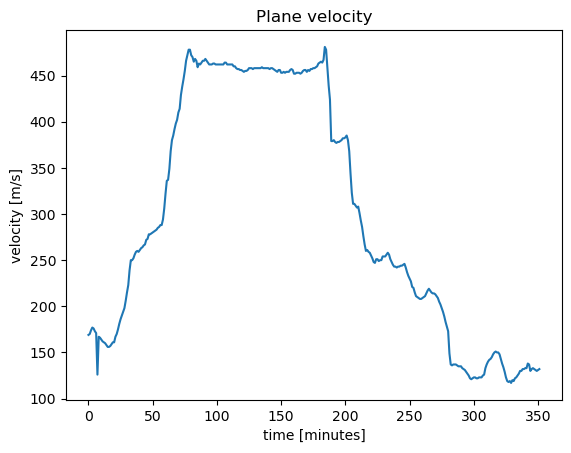

In [8]:
# create a velocity plot
plt.plot(velocities)
plt.xlabel('time [minutes]')
plt.ylabel('velocity [m/s]')
plt.title('Plane velocity')
plt.show()